In [ ]:
!pip install transformers
!pip install -q -U tensorflow-text
!pip install -q tf-models-official


     |████████████████████████████████| 3.4 MB 4.2 MB/s 
     |████████████████████████████████| 61 kB 510 kB/s 
     |████████████████████████████████| 3.3 MB 38.4 MB/s 
     |████████████████████████████████| 895 kB 53.6 MB/s 
     |████████████████████████████████| 596 kB 49.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 4.9 MB 3.7 MB/s 
     |████████████████████████████████| 1.8 MB 4.1 MB/s 
     |████████████████████████████████| 99 kB 9.1 MB/s 
     |████████████████████████████████| 1.1 MB 20.9 MB/s 
     |████████████████████████████████| 90 kB 9.8 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 213 kB 41.0 MB/s 
     |████████████████████████████████| 1.2 MB 29.5 MB/s 
     |████████████████████████████████| 352 kB 50.7 MB/s 
     |████████████████████████████████| 47.6 MB 1.

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt


In [ ]:
def ingest():
    data = pd.read_csv('/content/drive/MyDrive/COMP550/dataset.csv')
    data.drop(['movie_ids', 'ratings'], axis=1, inplace=True)
    data = data[data.review_texts.isnull() == False]
    data['ratings_binary'] = data['ratings_binary'].apply(lambda e : 1 if e == 'p' else 0)
    # data['review_texts'] = data['review_texts'].map(int)
    # data = data[data['review_texts'].isnull() == False]
    data.reset_index(inplace=True)
    data.drop(['index',"Unnamed: 0"], axis=1, inplace=True)
    print ('dataset loaded with shape', data.shape)
    return data

In [ ]:
data = ingest()

dataset loaded with shape (13439, 3)


In [ ]:
audience_data = data[data.sources == 'audience']
audience_data = audience_data.drop(["sources"], axis=1)
audience_data = audience_data.sample(frac=1).reset_index(drop=True)
critics_data = data[data.sources == 'critics']
critics_data = critics_data.drop("sources", axis=1)
critics_data = critics_data.sample(frac=1).reset_index(drop=True)

In [ ]:
aud_x_train, aud_x_test, aud_y_train, aud_y_test = train_test_split(np.array(audience_data.review_texts),
                                                    np.array(audience_data.ratings_binary), test_size=0.3)
aud_x_vali, aud_x_test, aud_y_vali, aud_y_test = train_test_split(aud_x_test,
                                                    aud_y_test, test_size=0.6)
cr_x_train, cr_x_test, cr_y_train, cr_y_test = train_test_split(np.array(critics_data.review_texts),
                                                    np.array(critics_data.ratings_binary), test_size=0.3)
cr_x_vali, cr_x_test, cr_y_vali, cr_y_test = train_test_split(cr_x_test,
                                                    cr_y_test, test_size=0.6)

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
aud_classifier_model = build_classifier_model()
cr_classifier_model = build_classifier_model()

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
def build_optimizer(train_size, epochs = 5):
  steps_per_epoch = train_size
  num_train_steps = steps_per_epoch * epochs
  num_warmup_steps = int(0.1*num_train_steps)

  init_lr = 3e-5
  optimizer = optimization.create_optimizer(init_lr=init_lr,
                                            num_train_steps=num_train_steps,
                                            num_warmup_steps=num_warmup_steps,
                                            optimizer_type='adamw')
  return optimizer

In [ ]:
epochs = 25

aud_optimizer = build_optimizer(len(aud_x_train), epochs)
cr_optimizer = build_optimizer(len(cr_x_train), epochs)


aud_classifier_model.compile(optimizer=aud_optimizer,
                         loss=loss,
                         metrics=metrics)

cr_classifier_model.compile(optimizer=cr_optimizer,
                         loss=loss,
                         metrics=metrics)

INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000
INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
aud_history = aud_classifier_model.fit(x=aud_x_train, y=aud_y_train,
                               validation_data=(aud_x_vali, aud_y_vali),
                               epochs=epochs)
cr_history = cr_classifier_model.fit(x=cr_x_train, y=cr_y_train,
                               validation_data=(cr_x_vali, cr_y_vali),
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
100/100 [==============================] - 868s 8s/step - loss: 1.0030 - binary_accuracy: 0.3483 - val_loss: 0.6156 - val_binary_accuracy: 0.5938
Epoch 2/5
100/100 [==============================] - 854s 9s/step - loss: 0.5765 - binary_accuracy: 0.6751 - val_loss: 0.5167 - val_binary_accuracy: 0.7500
Epoch 3/5
100/100 [==============================] - 852s 9s/step - loss: 0.4903 - binary_accuracy: 0.7526 - val_loss: 0.4318 - val_binary_accuracy: 0.8033
Epoch 4/5
100/100 [==============================] - 853s 9s/step - loss: 0.4001 - binary_accuracy: 0.8191 - val_loss: 0.3752 - val_binary_accuracy: 0.8125
Epoch 5/5
100/100 [==============================] - 848s 8s/step - loss: 0.3480 - binary_accuracy: 0.8434 - val_loss: 0.3622 - val_binary_accuracy: 0.8272
Epoch 1/5
195/195 [==============================] - 1666s 9s/step - loss: 0.6803 - binary_accuracy: 0.5624 - val_loss: 0.6453 -

In [ ]:
loss, accuracy = aud_classifier_model.evaluate(x=aud_x_test, y=aud_y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

loss, accuracy = cr_classifier_model.evaluate(x=cr_x_test, y=cr_y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

26/26 [==============================] - 3s 114ms/step - loss: 0.5678 - binary_accuracy: 0.8542
Loss: 0.5678142309188843
Accuracy: 0.8541666865348816
51/51 [==============================] - 6s 110ms/step - loss: 0.9268 - binary_accuracy: 0.8167
Loss: 0.9267702102661133
Accuracy: 0.8167082071304321


In [ ]:
def plot_history(history):
  history_dict = history.history
  print(history_dict.keys())

  acc = history_dict['binary_accuracy']
  val_acc = history_dict['val_binary_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)
  fig = plt.figure(figsize=(10, 6))
  fig.tight_layout()

  plt.subplot(2, 1, 1)
  # r is for "solid red line"
  plt.plot(epochs, loss, 'r', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  # plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(2, 1, 2)
  plt.plot(epochs, acc, 'r', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


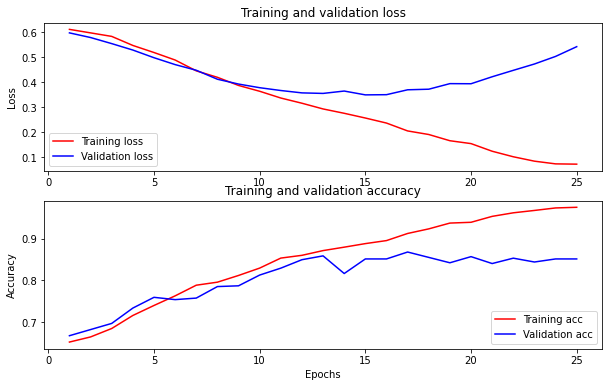

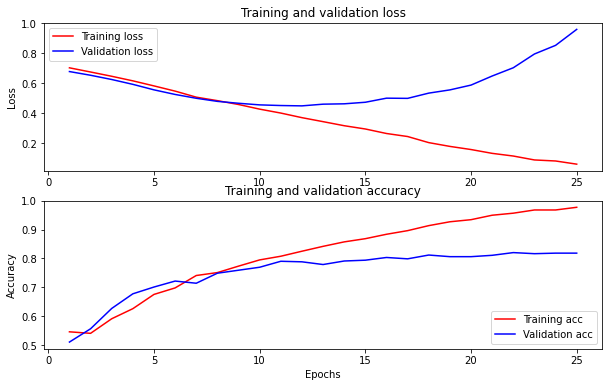

In [ ]:
plot_history(aud_history)
plot_history(cr_history)